In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.4819 - acc: 0.1001
Epoch 00001: val_loss improved from inf to 11.91867, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_1_conv_checkpoint/001-11.9187.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 12.4817 - acc: 0.1001 - val_loss: 11.9187 - val_acc: 0.1020
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.8724 - acc: 0.2380
Epoch 00002: val_loss did not improve from 11.91867
36805/36805 [==============================] - 53s 1ms/sample - loss: 10.8730 - acc: 0.2380 - val_loss: 13.2146 - val_acc: 0.1076
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.9487 - acc: 0.3188
Epoch 00003: val_loss did not improve from 11.91867
36805/36805 [==============================] - 52s 1ms/sample - loss: 9.9483 - acc: 0.3188 - val_loss: 13.

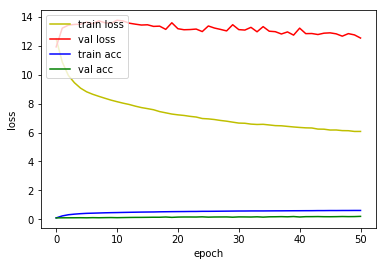

4815/4815 [==============================] - 3s 562us/sample - loss: 11.9385 - acc: 0.0976
Loss: 11.93846916642392 Accuracy: 0.09761163

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.2808 - acc: 0.2287
Epoch 00001: val_loss improved from inf to 5.80252, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_2_conv_checkpoint/001-5.8025.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 5.2814 - acc: 0.2287 - val_loss: 5.8025 - val_acc: 0.2416
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6279 - acc: 0.4417
Epoch 00002: val_loss did not improve from 5.80252
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.6283 - acc: 0.4417 - val_loss: 6.1157 - val_acc: 0.2835
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5722 - acc: 0.5854
Epoch 00003: val_loss did not improve from 5.80252
36805/36805 [==============

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4952 - acc: 0.9513
Epoch 00030: val_loss did not improve from 5.80252
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.4969 - acc: 0.9512 - val_loss: 8.1856 - val_acc: 0.4032
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5106 - acc: 0.9514
Epoch 00031: val_loss did not improve from 5.80252
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.5105 - acc: 0.9514 - val_loss: 8.8245 - val_acc: 0.3636
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4745 - acc: 0.9538
Epoch 00032: val_loss did not improve from 5.80252
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.4744 - acc: 0.9538 - val_loss: 8.3205 - val_acc: 0.3823
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5008 - acc: 0.9514
Epoch 00033: val_loss did not improve from 5.80252
36805/36805 [===========

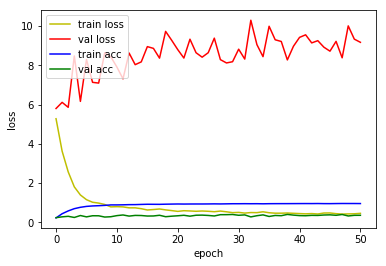

4815/4815 [==============================] - 4s 756us/sample - loss: 5.7383 - acc: 0.2517
Loss: 5.738269213798262 Accuracy: 0.2517134

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5055 - acc: 0.3839
Epoch 00001: val_loss improved from inf to 2.79580, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_3_conv_checkpoint/001-2.7958.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.5056 - acc: 0.3839 - val_loss: 2.7958 - val_acc: 0.3757
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1748 - acc: 0.6809
Epoch 00002: val_loss did not improve from 2.79580
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.1748 - acc: 0.6809 - val_loss: 2.9568 - val_acc: 0.3927
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5607 - acc: 0.8490
Epoch 00003: val_loss improved from 2.79580 to 2.45399, saving model to model/ch

36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9841
Epoch 00029: val_loss did not improve from 2.08229
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0788 - acc: 0.9841 - val_loss: 4.1735 - val_acc: 0.5064
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.9904
Epoch 00030: val_loss did not improve from 2.08229
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0524 - acc: 0.9904 - val_loss: 4.1048 - val_acc: 0.5246
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9889
Epoch 00031: val_loss did not improve from 2.08229
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0657 - acc: 0.9889 - val_loss: 4.3494 - val_acc: 0.4896
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9868
Epoch 00032: val_loss did not improve from 2.08229
36805/36805 [========================

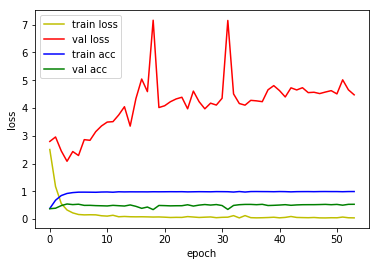

4815/4815 [==============================] - 4s 868us/sample - loss: 2.3179 - acc: 0.5076
Loss: 2.3179046772969722 Accuracy: 0.50758046

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9368 - acc: 0.4386
Epoch 00001: val_loss improved from inf to 1.68692, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_4_conv_checkpoint/001-1.6869.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.9369 - acc: 0.4386 - val_loss: 1.6869 - val_acc: 0.4955
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1744 - acc: 0.6508
Epoch 00002: val_loss improved from 1.68692 to 1.68286, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_4_conv_checkpoint/002-1.6829.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.1744 - acc: 0.6508 - val_loss: 1.6829 - val_acc: 0.5497
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.832

36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9947
Epoch 00029: val_loss did not improve from 1.67546
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0321 - acc: 0.9947 - val_loss: 2.0820 - val_acc: 0.6205
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9953
Epoch 00030: val_loss did not improve from 1.67546
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0290 - acc: 0.9953 - val_loss: 2.2228 - val_acc: 0.6122
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9951
Epoch 00031: val_loss did not improve from 1.67546
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0319 - acc: 0.9950 - val_loss: 2.5284 - val_acc: 0.5730
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9948
Epoch 00032: val_loss did not improve from 1.67546
36805/36805 [========================

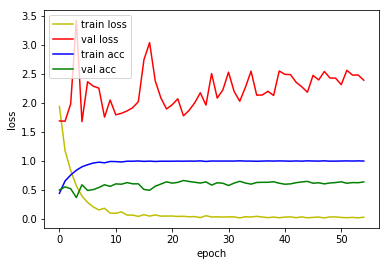

4815/4815 [==============================] - 4s 904us/sample - loss: 1.7769 - acc: 0.5518
Loss: 1.7769245119481072 Accuracy: 0.55181724

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7782 - acc: 0.4775
Epoch 00001: val_loss improved from inf to 2.01795, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_5_conv_checkpoint/001-2.0179.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 1.7782 - acc: 0.4775 - val_loss: 2.0179 - val_acc: 0.4384
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1839 - acc: 0.6488
Epoch 00002: val_loss did not improve from 2.01795
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.1839 - acc: 0.6488 - val_loss: 2.0855 - val_acc: 0.4556
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9284 - acc: 0.7244
Epoch 00003: val_loss improved from 2.01795 to 1.85675, saving model to model/

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9922
Epoch 00058: val_loss did not improve from 1.40007
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0342 - acc: 0.9922 - val_loss: 2.0751 - val_acc: 0.6567
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9961
Epoch 00059: val_loss did not improve from 1.40007
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0206 - acc: 0.9961 - val_loss: 1.8618 - val_acc: 0.6851
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9985
Epoch 00060: val_loss did not improve from 1.40007
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0124 - acc: 0.9984 - val_loss: 2.1980 - val_acc: 0.6494

1D_CNN_custom_tanh_BN_5_conv Model


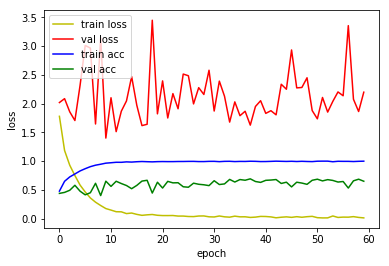

4815/4815 [==============================] - 5s 950us/sample - loss: 1.5837 - acc: 0.6066
Loss: 1.5837259600343239 Accuracy: 0.6066459

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7655 - acc: 0.4645
Epoch 00001: val_loss improved from inf to 1.65785, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_6_conv_checkpoint/001-1.6579.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 1.7655 - acc: 0.4645 - val_loss: 1.6579 - val_acc: 0.4948
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1922 - acc: 0.6424
Epoch 00002: val_loss did not improve from 1.65785
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.1921 - acc: 0.6424 - val_loss: 2.0746 - val_acc: 0.4384
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9790 - acc: 0.7086
Epoch 00003: val_loss did not improve from 1.65785
36805/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9889
Epoch 00028: val_loss did not improve from 1.12154
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0631 - acc: 0.9888 - val_loss: 1.9846 - val_acc: 0.6040
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9769
Epoch 00029: val_loss improved from 1.12154 to 1.09791, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_6_conv_checkpoint/029-1.0979.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0977 - acc: 0.9769 - val_loss: 1.0979 - val_acc: 0.7508
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.9882
Epoch 00030: val_loss did not improve from 1.09791
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0625 - acc: 0.9882 - val_loss: 1.1406 - val_acc: 0.7403
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0501 - acc: 0

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9936
Epoch 00057: val_loss did not improve from 1.03674
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0325 - acc: 0.9936 - val_loss: 1.1429 - val_acc: 0.7577
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9917
Epoch 00058: val_loss did not improve from 1.03674
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0383 - acc: 0.9916 - val_loss: 1.0815 - val_acc: 0.7799
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9933
Epoch 00059: val_loss did not improve from 1.03674
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0324 - acc: 0.9933 - val_loss: 1.0879 - val_acc: 0.7843
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9914
Epoch 00060: val_loss did not improve from 1.03674
36805/36805 [===========

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9973
Epoch 00116: val_loss did not improve from 1.00609
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0150 - acc: 0.9973 - val_loss: 1.2358 - val_acc: 0.7687
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9927
Epoch 00117: val_loss did not improve from 1.00609
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0291 - acc: 0.9927 - val_loss: 1.1059 - val_acc: 0.7990
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9987
Epoch 00118: val_loss did not improve from 1.00609
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0102 - acc: 0.9988 - val_loss: 1.2444 - val_acc: 0.7741
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9990
Epoch 00119: val_loss did not improve from 1.00609
36805/36805 [=======

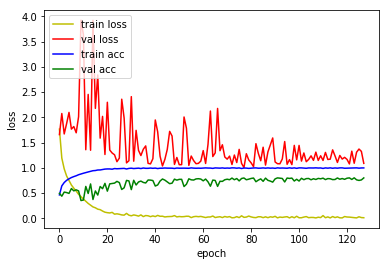

4815/4815 [==============================] - 5s 983us/sample - loss: 1.1556 - acc: 0.7583
Loss: 1.1556077417554884 Accuracy: 0.7582554

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8327 - acc: 0.4446
Epoch 00001: val_loss improved from inf to 2.16199, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_7_conv_checkpoint/001-2.1620.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.8326 - acc: 0.4446 - val_loss: 2.1620 - val_acc: 0.3676
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2131 - acc: 0.6402
Epoch 00002: val_loss improved from 2.16199 to 1.47300, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_7_conv_checkpoint/002-1.4730.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.2131 - acc: 0.6402 - val_loss: 1.4730 - val_acc: 0.5595
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.976

36800/36805 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9787
Epoch 00028: val_loss did not improve from 0.55361
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0913 - acc: 0.9787 - val_loss: 0.6949 - val_acc: 0.8225
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0937 - acc: 0.9787
Epoch 00029: val_loss did not improve from 0.55361
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0937 - acc: 0.9787 - val_loss: 0.9705 - val_acc: 0.7631
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0871 - acc: 0.9804
Epoch 00030: val_loss did not improve from 0.55361
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0871 - acc: 0.9804 - val_loss: 0.6721 - val_acc: 0.8188
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9823
Epoch 00031: val_loss did not improve from 0.55361
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9962
Epoch 00085: val_loss did not improve from 0.43561
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0183 - acc: 0.9962 - val_loss: 0.5218 - val_acc: 0.8796
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9964
Epoch 00086: val_loss did not improve from 0.43561
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0188 - acc: 0.9964 - val_loss: 0.6240 - val_acc: 0.8621
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9953
Epoch 00087: val_loss did not improve from 0.43561
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0225 - acc: 0.9953 - val_loss: 0.4549 - val_acc: 0.8977
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9989
Epoch 00088: val_loss did not improve from 0.43561
36805/36805 [========================

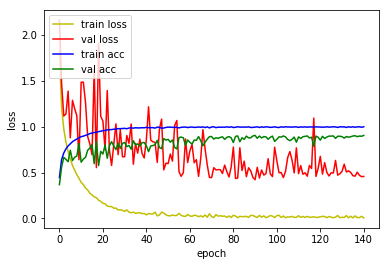

4815/4815 [==============================] - 5s 1000us/sample - loss: 0.5078 - acc: 0.8827
Loss: 0.5077504219976665 Accuracy: 0.88265836

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7356 - acc: 0.4780
Epoch 00001: val_loss improved from inf to 1.38018, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_8_conv_checkpoint/001-1.3802.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.7355 - acc: 0.4780 - val_loss: 1.3802 - val_acc: 0.5742
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0925 - acc: 0.6802
Epoch 00002: val_loss improved from 1.38018 to 1.06180, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_8_conv_checkpoint/002-1.0618.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.0924 - acc: 0.6802 - val_loss: 1.0618 - val_acc: 0.6818
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9992
Epoch 00055: val_loss did not improve from 0.24530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0083 - acc: 0.9992 - val_loss: 0.2596 - val_acc: 0.9376
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.24530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0255 - acc: 0.9940 - val_loss: 0.2721 - val_acc: 0.9315
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9970
Epoch 00057: val_loss did not improve from 0.24530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0149 - acc: 0.9969 - val_loss: 0.2572 - val_acc: 0.9338
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9910
Epoch 00058: val_loss did not improve from 0.24530
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9990
Epoch 00084: val_loss improved from 0.23686 to 0.23462, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_8_conv_checkpoint/084-0.2346.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0071 - acc: 0.9990 - val_loss: 0.2346 - val_acc: 0.9450
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.23462
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0050 - acc: 0.9993 - val_loss: 0.2384 - val_acc: 0.9415
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9965
Epoch 00086: val_loss did not improve from 0.23462
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0141 - acc: 0.9965 - val_loss: 0.4749 - val_acc: 0.8873
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9993
Epoch 00113: val_loss did not improve from 0.22757
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0044 - acc: 0.9993 - val_loss: 0.2504 - val_acc: 0.9478
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9993
Epoch 00114: val_loss did not improve from 0.22757
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0048 - acc: 0.9993 - val_loss: 0.2788 - val_acc: 0.9399
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9951
Epoch 00115: val_loss did not improve from 0.22757
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0190 - acc: 0.9951 - val_loss: 0.3370 - val_acc: 0.9238
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9967
Epoch 00116: val_loss did not improve from 0.22757
36805/36805 [=======

Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9979
Epoch 00143: val_loss did not improve from 0.22757
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0089 - acc: 0.9979 - val_loss: 0.4143 - val_acc: 0.9108
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9995
Epoch 00144: val_loss did not improve from 0.22757
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0038 - acc: 0.9995 - val_loss: 0.2585 - val_acc: 0.9434
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9996
Epoch 00145: val_loss did not improve from 0.22757
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0030 - acc: 0.9996 - val_loss: 0.2497 - val_acc: 0.9474
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9942
Epoch 00146: val_loss did not improve from 0.22757
36805/36805 [=======

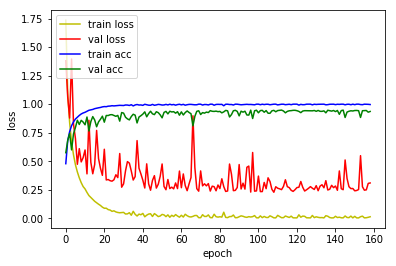

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3131 - acc: 0.9269
Loss: 0.3130880305344318 Accuracy: 0.92689514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4708 - acc: 0.5534
Epoch 00001: val_loss improved from inf to 1.05278, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_9_conv_checkpoint/001-1.0528.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 1.4709 - acc: 0.5534 - val_loss: 1.0528 - val_acc: 0.6718
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7586 - acc: 0.7730
Epoch 00002: val_loss improved from 1.05278 to 0.61592, saving model to model/checkpoint/1D_CNN_custom_tanh_BN_9_conv_checkpoint/002-0.6159.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.7585 - acc: 0.7730 - val_loss: 0.6159 - val_acc: 0.8164
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5209

36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9937
Epoch 00054: val_loss did not improve from 0.19444
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0212 - acc: 0.9937 - val_loss: 0.2606 - val_acc: 0.9290
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9954
Epoch 00055: val_loss did not improve from 0.19444
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0170 - acc: 0.9954 - val_loss: 0.2295 - val_acc: 0.9441
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9994
Epoch 00056: val_loss did not improve from 0.19444
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0046 - acc: 0.9994 - val_loss: 0.1968 - val_acc: 0.9488
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9991
Epoch 00057: val_loss did not improve from 0.19444
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9968
Epoch 00084: val_loss did not improve from 0.18881
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0122 - acc: 0.9968 - val_loss: 0.2106 - val_acc: 0.9499
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9974
Epoch 00085: val_loss did not improve from 0.18881
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0112 - acc: 0.9974 - val_loss: 0.1987 - val_acc: 0.9522
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9997
Epoch 00086: val_loss did not improve from 0.18881
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0023 - acc: 0.9997 - val_loss: 0.2103 - val_acc: 0.9513
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9968
Epoch 00087: val_loss did not improve from 0.18881
36805/36805 [===========

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9995
Epoch 00114: val_loss did not improve from 0.18881
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0030 - acc: 0.9995 - val_loss: 0.2192 - val_acc: 0.9504
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9988
Epoch 00115: val_loss did not improve from 0.18881
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0052 - acc: 0.9988 - val_loss: 0.2392 - val_acc: 0.9464
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9960
Epoch 00116: val_loss did not improve from 0.18881
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0132 - acc: 0.9960 - val_loss: 0.2093 - val_acc: 0.9518
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9996
Epoch 00117: val_loss did not improve from 0.18881
36805/36805 [=======

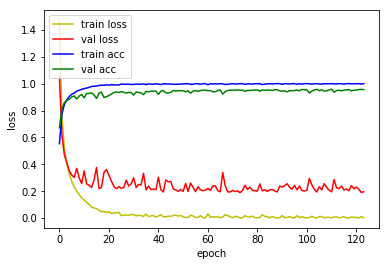

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2772 - acc: 0.9377
Loss: 0.27723436721001954 Accuracy: 0.9376947



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_tanh_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [9]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable params: 2,048,128
____________________

4815/4815 [==============================] - 5s 954us/sample - loss: 1.7769 - acc: 0.5518
Loss: 1.7769245119481072 Accuracy: 0.55181724

1D_CNN_custom_tanh_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5078 - acc: 0.8827
Loss: 0.5077504219976665 Accuracy: 0.88265836

1D_CNN_custom_tanh_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 16

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2772 - acc: 0.9377
Loss: 0.27723436721001954 Accuracy: 0.9376947


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable params: 2,048,128
____________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 2.6802 - acc: 0.5907
Loss: 2.680159795866082 Accuracy: 0.5906542

1D_CNN_custom_tanh_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 1600

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5650 - acc: 0.8806
Loss: 0.5649968348064403 Accuracy: 0.8805815

1D_CNN_custom_tanh_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 160

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2925 - acc: 0.9381
Loss: 0.2924639905780662 Accuracy: 0.93811005
